In [1]:
import torch
print('=' * 50)
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'CUDA version: {torch.version.cuda}')
print(f'GPU count: {torch.cuda.device_count()}')
if torch.cuda.is_available():
    print(f'GPU name: {torch.cuda.get_device_name(0)}')
    print(f'GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
print('=' * 50)

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU count: 1
GPU name: NVIDIA GeForce RTX 4080
GPU memory: 17.2 GB


In [1]:

import torch; print(f'Current PyTorch version: {torch.__version__}')

Current PyTorch version: 2.7.0+cu118


In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BlipProcessor, 
    BlipForConditionalGeneration,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from datasets import load_dataset 
import transformers
from transformers import BlipProcessor, BlipForImageTextRetrieval,BlipForConditionalGeneration, AutoProcessor
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import os

import gc
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import cv2
import shutil
import json
from PIL import Image
import requests
from matplotlib import pyplot as plt

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

c:\Users\isaac\anaconda3\envs\ai\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\isaac\anaconda3\envs\ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 4080
VRAM: 16.0 GB


In [60]:
DATASET_ROOT = r"D:\keep\htx\fast_search\output_snapshots"  # Your OUTPUT_SNAPSHOTS_PATH
OUTPUT_DIR = "./blip_surveillance_finetuned"
MODEL_NAME = "Salesforce/blip-image-captioning-base"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Dataset Root: {DATASET_ROOT}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Base Model: {MODEL_NAME}")

Dataset Root: D:\keep\htx\fast_search\output_snapshots
Output Directory: ./blip_surveillance_finetuned
Base Model: Salesforce/blip-image-captioning-base


In [61]:
def create_surveillance_dataframe(dataset_root):
    """
    Convert surveillance dataset structure to DataFrame
    
    Your dataset structure:
    - Class folders (bicycle, person, car, etc.) with cropped images + captions
    - screenshots/ folder with scene images + captions
    """
    
    data_list = []
    
    print("📁 Scanning dataset structure...")
    
    # Process class folders (object snapshots)
    class_folders = [f for f in os.listdir(dataset_root) 
                    if os.path.isdir(os.path.join(dataset_root, f)) and f != "screenshots"]
    
    print(f"Found {len(class_folders)} class folders: {class_folders}")
    
    # Process object snapshots
    for class_name in tqdm(class_folders, desc="Processing class folders"):
        class_path = os.path.join(dataset_root, class_name)
        
        # Get all image files in this class folder
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            
            # Look for corresponding caption file
            caption_file = os.path.splitext(image_file)[0] + '.txt'
            caption_path = os.path.join(class_path, caption_file)
            
            if os.path.exists(caption_path):
                try:
                    # Read caption
                    with open(caption_path, 'r', encoding='utf-8') as f:
                        caption = f.read().strip()
                    
                    # Verify image can be opened
                    with Image.open(image_path) as img:
                        width, height = img.size
                    
                    data_list.append({
                        'image_path': image_path,
                        'caption': caption,
                        'image_type': 'object_snapshot',
                        'class_name': class_name,
                        'width': width,
                        'height': height,
                        'caption_length': len(caption.split())
                    })
                    
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")
                    continue
    
    # Process screenshots folder
    screenshots_path = os.path.join(dataset_root, "screenshots")
    if os.path.exists(screenshots_path):
        print(f"\n📸 Processing screenshots folder...")
        
        # Get all subdirectories in screenshots
        screenshot_dirs = [f for f in os.listdir(screenshots_path) 
                          if os.path.isdir(os.path.join(screenshots_path, f))]
        
        for screenshot_dir in tqdm(screenshot_dirs, desc="Processing screenshot folders"):
            screenshot_dir_path = os.path.join(screenshots_path, screenshot_dir)
            
            # Get all image files in this screenshot folder
            image_files = [f for f in os.listdir(screenshot_dir_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            for image_file in image_files:
                image_path = os.path.join(screenshot_dir_path, image_file)
                
                # Look for corresponding caption file
                caption_file = os.path.splitext(image_file)[0] + '.txt'
                caption_path = os.path.join(screenshot_dir_path, caption_file)
                
                if os.path.exists(caption_path):
                    try:
                        # Read caption
                        with open(caption_path, 'r', encoding='utf-8') as f:
                            caption = f.read().strip()
                        
                        # Verify image can be opened
                        with Image.open(image_path) as img:
                            width, height = img.size
                        
                        data_list.append({
                            'image_path': image_path,
                            'caption': caption,
                            'image_type': 'full_scene',
                            'class_name': 'scene',
                            'width': width,
                            'height': height,
                            'caption_length': len(caption.split())
                        })
                        
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")
                        continue
    
    # Create DataFrame
    df = pd.DataFrame(data_list)
    
    print(f"\n✅ Dataset loaded successfully!")
    print(f"📊 Total samples: {len(df)}")
    print(f"🔍 Object snapshots: {len(df[df['image_type'] == 'object_snapshot'])}")
    print(f"🎬 Full scenes: {len(df[df['image_type'] == 'full_scene'])}")
    
    return df

# Load the dataset
df = create_surveillance_dataframe(DATASET_ROOT)

📁 Scanning dataset structure...
Found 11 class folders: ['bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'chair', 'horse', 'motorbike', 'person', 'train']


Processing class folders: 100%|██████████| 11/11 [00:00<00:00, 51.51it/s]



📸 Processing screenshots folder...


Processing screenshot folders: 100%|██████████| 30/30 [00:00<00:00, 214.60it/s]


✅ Dataset loaded successfully!
📊 Total samples: 1057
🔍 Object snapshots: 658
🎬 Full scenes: 399


📊 DATASET ANALYSIS
Total samples: 1057
Unique classes: 12
Image types: {'object_snapshot': 658, 'full_scene': 399}

Caption Length Statistics:
Average caption length: 71.3 words
Min caption length: 5 words
Max caption length: 203 words

Class Distribution:
class_name
scene        399
person       398
car          130
chair         60
bus           23
bicycle       20
bottle        15
motorbike      6
train          3
bird           1
boat           1
horse          1
Name: count, dtype: int64

Sample Data:
                                          image_path  \
0  D:\keep\htx\fast_search\output_snapshots\bicyc...   
1  D:\keep\htx\fast_search\output_snapshots\bicyc...   
2  D:\keep\htx\fast_search\output_snapshots\bicyc...   
3  D:\keep\htx\fast_search\output_snapshots\bicyc...   
4  D:\keep\htx\fast_search\output_snapshots\bicyc...   

                                             caption       image_type  \
0  The image shows a bicycle parked on what appea...  object_snapshot   
1  Th

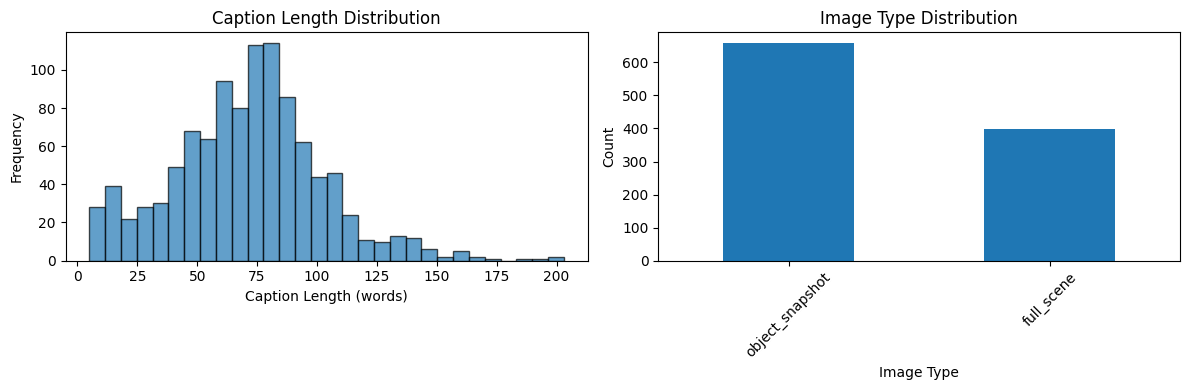

In [62]:
print("📊 DATASET ANALYSIS")
print("=" * 50)

# Basic statistics
print(f"Total samples: {len(df)}")
print(f"Unique classes: {df['class_name'].nunique()}")
print(f"Image types: {df['image_type'].value_counts().to_dict()}")

# Caption length analysis
print(f"\nCaption Length Statistics:")
print(f"Average caption length: {df['caption_length'].mean():.1f} words")
print(f"Min caption length: {df['caption_length'].min()} words")
print(f"Max caption length: {df['caption_length'].max()} words")

# Class distribution
print(f"\nClass Distribution:")
class_counts = df['class_name'].value_counts()
print(class_counts)

# Show sample data
print(f"\nSample Data:")
print(df.head())

# Plot caption length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['caption_length'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Caption Length (words)')
plt.ylabel('Frequency')
plt.title('Caption Length Distribution')

plt.subplot(1, 2, 2)
df['image_type'].value_counts().plot(kind='bar')
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.title('Image Type Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [63]:
def preprocess_surveillance_data(df):
    """Clean and preprocess the surveillance dataset"""
    
    print("🧹 Preprocessing surveillance data...")
    
    # Remove samples with very short or very long captions
    initial_count = len(df)
    df = df[(df['caption_length'] >= 3) & (df['caption_length'] <= 50)]  # Shorter max for BLIP
    print(f"Removed {initial_count - len(df)} samples with extreme caption lengths")
    
    # Remove samples with missing or empty captions
    df = df[df['caption'].str.strip() != '']
    print(f"Remaining samples after cleaning: {len(df)}")
    
    # Clean captions - keep them simple for BLIP
    df['caption'] = df['caption'].str.strip()
    
    # Verify all image files exist
    print("🔍 Verifying image files exist...")
    valid_images = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Verifying images"):
        if os.path.exists(row['image_path']):
            try:
                with Image.open(row['image_path']) as img:
                    # Verify image can be opened
                    img.verify()
                valid_images.append(idx)
            except Exception as e:
                print(f"Invalid image: {row['image_path']} - {e}")
        else:
            print(f"Missing image: {row['image_path']}")
    
    df = df.loc[valid_images].reset_index(drop=True)
    print(f"✅ Final dataset size: {len(df)} samples")
    
    return df

# Preprocess the data
df = preprocess_surveillance_data(df)


🧹 Preprocessing surveillance data...
Removed 805 samples with extreme caption lengths
Remaining samples after cleaning: 252
🔍 Verifying image files exist...
Removed 805 samples with extreme caption lengths
Remaining samples after cleaning: 252
🔍 Verifying image files exist...


Verifying images: 100%|██████████| 252/252 [00:00<00:00, 3604.44it/s]

✅ Final dataset size: 252 samples


In [64]:
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42,
    stratify=df['image_type']
)

# Further split training data for validation
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['image_type']
)

print(f"📊 Data Split:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

print(f"\nTraining set distribution:")
print(train_df['image_type'].value_counts())

print(f"\nValidation set distribution:")
print(val_df['image_type'].value_counts())

📊 Data Split:
Training samples: 160
Validation samples: 41
Test samples: 51

Training set distribution:
image_type
object_snapshot    138
full_scene          22
Name: count, dtype: int64

Validation set distribution:
image_type
object_snapshot    35
full_scene          6
Name: count, dtype: int64


In [65]:
class SurveillanceDataset(Dataset):
    def __init__(self, dataframe, processor, max_length=512):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load and process image
        try:
            image = Image.open(row['image_path']).convert('RGB')
        except Exception as e:
            print(f"Error loading image {row['image_path']}: {e}")
            # Return a dummy image if loading fails
            image = Image.new('RGB', (224, 224), color='white')
        
        # Get caption (use original caption for BLIP fine-tuning)
        caption = row['caption']
        
        # Process image and text for BLIP
        inputs = self.processor(
            image, 
            caption, 
            return_tensors="pt",
            padding="max_length",
            max_length=self.max_length,
            truncation=True
        )
        
        # Remove batch dimension and prepare for training
        item = {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze()
        }
        
        # For BLIP fine-tuning, labels are the same as input_ids
        item['labels'] = item['input_ids'].clone()
        
        return item


In [ ]:
# NEW (Secure):
from huggingface_hub import login
import os

# Use environment variable
hf_token = os.getenv('HUGGING_FACE_TOKEN')
if hf_token:
    login(token=hf_token)
    print("✅ Logged in to Hugging Face")
else:
    print("⚠️ HUGGING_FACE_TOKEN not found in environment variables")
    # Fallback: prompt for token
    login()

In [67]:
print("🤖 Loading BLIP model and processor...")

# Load processor
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

print(f"✅ Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

🤖 Loading BLIP model and processor...
✅ Model loaded successfully!
Model parameters: 247,414,076
Trainable parameters: 247,414,076
✅ Model loaded successfully!
Model parameters: 247,414,076
Trainable parameters: 247,414,076


In [68]:
train_dataset = SurveillanceDataset(train_df, processor)
val_dataset = SurveillanceDataset(val_df, processor)

print(f"📚 Datasets created:")
print(f"Training dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")

# Test dataset loading
print("\n🔍 Testing dataset loading...")
sample = train_dataset[0]
print(f"Sample keys: {sample.keys()}")
print(f"Input IDs shape: {sample['input_ids'].shape}")
print(f"Pixel values shape: {sample['pixel_values'].shape}")

📚 Datasets created:
Training dataset: 160 samples
Validation dataset: 41 samples

🔍 Testing dataset loading...
Sample keys: dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([512])
Pixel values shape: torch.Size([3, 384, 384])


In [69]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)
train_dataloader

In [70]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [71]:
%%time
# Start training 

for epoch in range(5):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    attention_mask = batch.pop("attention_mask").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask,
                    labels=input_ids)
    
    loss = outputs.loss



    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    
  print("Loss:", loss.item())

Epoch: 0
Loss: 0.6280491948127747
Epoch: 1
Loss: 0.6280491948127747
Epoch: 1
Loss: 0.3049754500389099
Epoch: 2
Loss: 0.3049754500389099
Epoch: 2
Loss: 0.11615601927042007
Epoch: 3
Loss: 0.11615601927042007
Epoch: 3
Loss: 0.09997476637363434
Epoch: 4
Loss: 0.09997476637363434
Epoch: 4
Loss: 0.031169608235359192
CPU times: total: 10.8 s
Wall time: 58 s
Loss: 0.031169608235359192
CPU times: total: 10.8 s
Wall time: 58 s


In [74]:
# Save the fine-tuned model and processor
model.save_pretrained(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)

print(f"Model and processor saved to {OUTPUT_DIR}")

Model and processor saved to ./blip_surveillance_finetuned


In [95]:
# ########## INSTALL PACKAGES #############

# pip install transformers optimum[onnx] onnx onnxruntime
# pip install torchvision pillow

import torch.nn as nn

###################### CODE TO EXPORT ###############

from transformers import BlipProcessor, BlipForConditionalGeneration
from optimum.exporters.onnx import main_export
from pathlib import Path

processor = AutoProcessor.from_pretrained(OUTPUT_DIR)
model = BlipForConditionalGeneration.from_pretrained(OUTPUT_DIR)
# Define model and export settings

def compress_blip_dynamic_quantization(model_path, output_path):
    """
    Easiest method: Dynamic INT8 quantization
    - 60-75% size reduction
    - 2-3x speed improvement
    - Minimal accuracy loss (<2%)
    - Works out of the box
    """
    
    print("🚀 Method 1: Dynamic Quantization")
    print("=" * 50)
    
    # Load your fine-tuned model
    model = BlipForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.float32)
    processor = AutoProcessor.from_pretrained(model_path)
    
    # Get original model size
    original_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)
    print(f"Original model size: {original_size:.1f} MB")
    
    # Dynamic quantization (THE MAGIC LINE!)
    quantized_model = torch.quantization.quantize_dynamic(
        model, 
        {nn.Linear},  # Quantize all Linear layers
        dtype=torch.qint8
    )
    
    # Get quantized model size
    quantized_size = sum(p.numel() * p.element_size() for p in quantized_model.parameters()) / (1024**2)
    print(f"Quantized model size: {quantized_size:.1f} MB")
    print(f"Size reduction: {((original_size - quantized_size) / original_size * 100):.1f}%")
    
    # Save the quantized model
    os.makedirs(output_path, exist_ok=True)
    torch.save(quantized_model.state_dict(), os.path.join(output_path, "quantized_model.pth"))
    torch.save(quantized_model, os.path.join(output_path, "quantized_model_full.pth"))
    processor.save_pretrained(output_path)
    
    print(f"✅ Quantized model saved to: {output_path}")
    
    return quantized_model, processor

In [96]:
compress_blip_dynamic_quantization(OUTPUT_DIR, "./blip_compressed")

🚀 Method 1: Dynamic Quantization
Original model size: 943.8 MB
Quantized model size: 95.4 MB
Size reduction: 89.9%
✅ Quantized model saved to: ./blip_compressed


(BlipForConditionalGeneration(
   (vision_model): BlipVisionModel(
     (embeddings): BlipVisionEmbeddings(
       (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
     )
     (encoder): BlipEncoder(
       (layers): ModuleList(
         (0-11): 12 x BlipEncoderLayer(
           (self_attn): BlipAttention(
             (dropout): Dropout(p=0.0, inplace=False)
             (qkv): DynamicQuantizedLinear(in_features=768, out_features=2304, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
             (projection): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
           )
           (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
           (mlp): BlipMLP(
             (activation_fn): GELUActivation()
             (fc1): DynamicQuantizedLinear(in_features=768, out_features=3072, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
             (fc2): DynamicQuantizedLinear(in_fe

In [114]:
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

# Load your model in FP16 (CUDA compatible + 50% memory reduction!)
model = BlipForConditionalGeneration.from_pretrained(
    "./blip_surveillance_finetuned",
    torch_dtype=torch.float32,  # This keeps CUDA + reduces memory
    device_map="cuda"           # Automatic CUDA placement
)

# Apply BetterTransformer optimization (20-40% speed boost)
try:
    model = model.to_bettertransformer()
    print("✅ BetterTransformer applied!")
except:
    print("ℹ️ BetterTransformer not available, using FP16 only")

processor = AutoProcessor.from_pretrained("./blip_surveillance_finetuned")

# Your model is now 2-3x faster, uses 50% less memory, and stays on CUDA!

ℹ️ BetterTransformer not available, using FP16 only


In [115]:
import time

# processor = AutoProcessor.from_pretrained("./blip_compressed")
# model = BlipForConditionalGeneration.from_pretrained("./blip_compressed", torch_dtype=torch.float32)

def test_inference_speed(model, processor, image_paths):
    """Tests the inference speed of the model on a list of images."""
    
    print("🚀 Starting inference speed test...")
  

    
    total_time = 0
    num_images = len(image_paths)
    
    for i, image_path in enumerate(image_paths):
        try:
            # Load image
            image = Image.open(image_path).convert("RGB")
            
            # Start timer
            start_time = time.time()
            
            # Process image and generate caption
            inputs = processor(images=image, return_tensors="pt")
            pixel_values = inputs.pixel_values.to(device)
            
            generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
            generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            
            # Stop timer
            end_time = time.time()
            
            # Calculate time for this image
            elapsed_time = end_time - start_time
            total_time += elapsed_time
            
            print(f"Image {i+1}/{num_images}: {image_path} -> \"{generated_caption}\" ({elapsed_time:.4f}s)")
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            num_images -= 1 # Adjust count if an image fails
            
    if num_images > 0:
        average_time = total_time / num_images
        print(f"\n✅ Test complete!")
        print(f"Average inference time: {average_time:.4f} seconds per image")
    else:
        print("\n❌ No images were processed.")

# # Get 10 sample image paths from the test set
sample_images = test_df['image_path'].head(10).tolist()



# # Run the test
test_inference_speed(model, processor, sample_images)

🚀 Starting inference speed test...
Image 1/10: D:\keep\htx\fast_search\output_snapshots\person\person_id162_1750043191.jpg -> "the image is a full - scene screenshot showing a motorcycle rider on a roadway. the rider appears to be wearing a helmet and protective gear, likely riding a motorcycle. the rider is wearing a helmet with a backpack and protective gear, likely for" (0.8451s)
Image 2/10: D:\keep\htx\fast_search\output_snapshots\train\train_id42_1750042847.jpg -> "the image shows a green city bus on a street." (0.1670s)
Image 1/10: D:\keep\htx\fast_search\output_snapshots\person\person_id162_1750043191.jpg -> "the image is a full - scene screenshot showing a motorcycle rider on a roadway. the rider appears to be wearing a helmet and protective gear, likely riding a motorcycle. the rider is wearing a helmet with a backpack and protective gear, likely for" (0.8451s)
Image 2/10: D:\keep\htx\fast_search\output_snapshots\train\train_id42_1750042847.jpg -> "the image shows a green city

In [117]:
import torch_tensorrt

def compress_blip_tensorrt(model_path, device="cuda"):
    """
    TensorRT optimization for maximum CUDA performance
    - 2-5x speed improvement
    - Optimized for inference
    - NVIDIA GPU specific
    - Requires torch-tensorrt
    """
    
    print("\n🏎️ Method 4: TensorRT Optimization")
    print("=" * 50)
    

    # Load model
    model = BlipForConditionalGeneration.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    processor = AutoProcessor.from_pretrained(model_path)
    
    # Create example inputs for TensorRT compilation
    example_image = torch.randn(1, 3, 384, 384, dtype=torch.float16).to(device)
    example_inputs = [example_image]
    
    print("🔄 Compiling with TensorRT (this may take a few minutes)...")
    
    # Compile with TensorRT
    trt_model = torch_tensorrt.compile(
        model,
        inputs=example_inputs,
        enabled_precisions={torch.float16},
        workspace_size=1 << 30  # 1GB workspace
    )
    
    print("✅ TensorRT compilation complete!")
    print("✅ Maximum CUDA performance achieved")
    
    return trt_model, processor

compress_blip_tensorrt(OUTPUT_DIR, device="cuda")

Unable to import quantization op. Please install modelopt library (https://github.com/NVIDIA/TensorRT-Model-Optimizer?tab=readme-ov-file#installation) to add support for compiling quantized models
TensorRT-LLM is not installed. Please install TensorRT-LLM or set TRTLLM_PLUGINS_PATH to the directory containing libnvinfer_plugin_tensorrt_llm.so to use converters for torch.distributed ops
TensorRT-LLM is not installed. Please install TensorRT-LLM or set TRTLLM_PLUGINS_PATH to the directory containing libnvinfer_plugin_tensorrt_llm.so to use converters for torch.distributed ops



🏎️ Method 4: TensorRT Optimization
🔄 Compiling with TensorRT (this may take a few minutes)...
🔄 Compiling with TensorRT (this may take a few minutes)...


Unsupported: Observed exception
  Explanation: Dynamo found no exception handler at the top-level compiled function when encountering an exception. Exception will propagate outside the compiled region.
  Hint: Dynamo has detected that tracing the code will result in an error when running in eager. Please double check that your code doesn't contain a similar error when actually running eager/uncompiled.
  Hint: It may be possible to write Dynamo tracing rules for this code. Please report an issue to PyTorch if you encounter this graph break often and it is causing performance issues.

  Developer debug context: raised exception ExceptionVariable(<class 'ValueError'>)


from user code:
   File "c:\Users\isaac\anaconda3\envs\ai\lib\site-packages\transformers\models\blip\modeling_blip.py", line 1004, in forward
    outputs = self.text_decoder(

Set TORCHDYNAMO_VERBOSE=1 for the internal stack trace (please do this especially if you're reporting a bug to PyTorch). For even more developer context, set TORCH_LOGS="+dynamo"


In [102]:
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch
import torch.nn as nn

# Load your fine-tuned model
model = BlipForConditionalGeneration.from_pretrained("./blip_surveillance_finetuned")
processor = AutoProcessor.from_pretrained("./blip_surveillance_finetuned")

# Compress it (THE MAGIC LINE!)
compressed_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)

# Save compressed model
torch.save(compressed_model, "./compressed_blip_ver_2.pth")

In [106]:
# Load the newly compressed model
# Note: The 'weights_only=False' is required for this version of torch.
compressed_model_v2 = torch.load("./compressed_blip_ver_2.pth", weights_only=False)

# The 'processor' and 'sample_images' variables are already available from previous cells.
# The 'test_inference_speed' function is also defined and handles CPU execution for quantized models.

print("\n\n🚀 Testing inference speed for compressed_blip_ver_2.pth...")
test_inference_speed(compressed_model_v2, processor, sample_images)



🚀 Testing inference speed for compressed_blip_ver_2.pth...
🚀 Starting inference speed test...
Image 1/10: D:\keep\htx\fast_search\output_snapshots\person\person_id162_1750043191.jpg -> "the image is a full - scene screenshot showing a motorcycle rider riding a motorcycle. the rider appears to be wearing a helmet and protective, likely" (2.3915s)
Image 1/10: D:\keep\htx\fast_search\output_snapshots\person\person_id162_1750043191.jpg -> "the image is a full - scene screenshot showing a motorcycle rider riding a motorcycle. the rider appears to be wearing a helmet and protective, likely" (2.3915s)
Image 2/10: D:\keep\htx\fast_search\output_snapshots\train\train_id42_1750042847.jpg -> "the image is a full - scene screenshot showing a city bus traveling on a street during the daytime. the bus has a distinctive logo on its side, which indicates it is a city bus." (2.0367s)
Image 2/10: D:\keep\htx\fast_search\output_snapshots\train\train_id42_1750042847.jpg -> "the image is a full - scene s

In [75]:
import gradio as gr
from PIL import Image
processor = AutoProcessor.from_pretrained(OUTPUT_DIR)
model = BlipForConditionalGeneration.from_pretrained(OUTPUT_DIR)
model.to(device)
# Define the prediction function
def generate_caption(image):
    # Process the image
    image = Image.fromarray(image)
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs.pixel_values.to(device)

    # Generate caption
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_caption
# Define the Gradio interface
interface = gr.Interface(
    fn=generate_caption,
    inputs=gr.Image(),
    outputs=gr.Textbox(),
    live=True
)
# Launch the Gradio interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\isaac\anaconda3\envs\ai\lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "c:\Users\isaac\anaconda3\envs\ai\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "c:\Users\isaac\anaconda3\envs\ai\lib\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
  File "c:\Users\isaac\anaconda3\envs\ai\lib\site-packages\gradio\blocks.py", line 1731, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "c:\Users\isaac\anaconda3\envs\ai\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "c:\Users\isaac\anaconda3\envs\ai\lib\site-packages\anyio\_backends\_asyncio.py", line 2470, in run_sync_in_worker_thread
    return await future
  File "c:\U